<a href="https://colab.research.google.com/github/bcgsc/pori/blob/feature%2Fcolab-notebooks/docs/ipr/scripting/RNA_Expression_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computing RNA Expression Correlations

## Download the Data

First we need to download the dataset we will use. We are going to use the TCGA data here since it is publically available and well known ([UCSC Xena TCGA PANCAN](https://xenabrowser.net/datapages/?cohort=TCGA%20Pan-Cancer%20(PANCAN))). We will download the TPM matrix as well as the corresponding metadata file

In [ ]:
!wget https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/tcga_RSEM_gene_tpm.gz
!wget https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/Survival_SupplementalTable_S1_20171025_xena_sp

--2021-06-09 20:42:06--  https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/tcga_RSEM_gene_tpm.gz
Resolving toil-xena-hub.s3.us-east-1.amazonaws.com (toil-xena-hub.s3.us-east-1.amazonaws.com)... 52.217.135.122
Connecting to toil-xena-hub.s3.us-east-1.amazonaws.com (toil-xena-hub.s3.us-east-1.amazonaws.com)|52.217.135.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740772247 (706M) [binary/octet-stream]
Saving to: ‘tcga_RSEM_gene_tpm.gz’

tcga_RSEM_gene_tpm. 100%[===================>] 706.46M  32.5MB/s    in 23s     

2021-06-09 20:42:30 (30.9 MB/s) - ‘tcga_RSEM_gene_tpm.gz’ saved [740772247/740772247]

--2021-06-09 20:42:30--  https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/Survival_SupplementalTable_S1_20171025_xena_sp
Resolving tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com (tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com)... 52.216.82.189
Connecting to tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com (tcga-pancan-atlas-hub.s3

The matrix we have downloaded is very large as it contains many different disease cohorts. For the purposes of this tutorial we want a smaller dataset so we are going to choose the smallest TCGA cohort, CHOL. To do this we need to use the metadata file to subset the main matrix file

## Install Dependencies

For the following tutorial we are going to use some common data processing and visualization libraries in python: seaborn and pandas. We need to install them before we proceed

In [ ]:
!pip install pandas seaborn

## Create the Disease Matrix



First read the metadata file


In [ ]:
import json

import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

sns.set_style('whitegrid')

In [ ]:
meta_df = pd.read_csv('Survival_SupplementalTable_S1_20171025_xena_sp', sep='\t')
meta_df

,sample,_PATIENT,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,menopause_status,birth_days_to,vital_status,tumor_status,last_contact_days_to,death_days_to,cause_of_death,new_tumor_event_type,new_tumor_event_site,new_tumor_event_site_other,new_tumor_event_dx_days_to,treatment_outcome_first_course,margin_status,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,TCGA-OR-A5J1-01,TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II,NaN,Adrenocortical carcinoma- Usual Type,NaN,2000.0,NaN,-21496.0,Dead,WITH TUMOR,NaN,1355.0,NaN,Distant Metastasis,Peritoneal Surfaces,NaN,754.0,Complete Remission/Response,NaN,NaN,1.0,1355.0,1.0,1355.0,1.0,754.0,1.0,754.0,NaN
1,TCGA-OR-A5J2-01,TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV,NaN,Adrenocortical carcinoma- Usual Type,NaN,2004.0,NaN,-16090.0,Dead,WITH TUMOR,NaN,1677.0,NaN,Distant Metastasis,Soft Tissue,NaN,289.0,Progressive Disease,NaN,NaN,1.0,1677.0,1.0,1677.0,NaN,NaN,1.0,289.0,NaN
2,TCGA-OR-A5J3-01,TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III,NaN,Adrenocortical carcinoma- Usual Type,NaN,2008.0,NaN,-8624.0,Alive,WITH TUMOR,2091.0,NaN,NaN,Distant Metastasis,Lung,NaN,53.0,Complete Remission/Response,NaN,NaN,0.0,2091.0,0.0,2091.0,1.0,53.0,1.0,53.0,NaN
3,TCGA-OR-A5J4-01,TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV,NaN,Adrenocortical carcinoma- Usual Type,NaN,2000.0,NaN,-8451.0,Dead,WITH TUMOR,NaN,423.0,NaN,Locoregional Recurrence,Peritoneal Surfaces,NaN,126.0,Progressive Disease,NaN,NaN,1.0,423.0,1.0,423.0,NaN,NaN,1.0,126.0,NaN
4,TCGA-OR-A5J5-01,TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III,NaN,Adrenocortical carcinoma- Usual Type,NaN,2000.0,NaN,-11171.0,Dead,WITH TUMOR,NaN,365.0,NaN,Locoregional Recurrence,"Other, specify",vena cava thrombus,50.0,Progressive Disease,NaN,NaN,1.0,365.0,1.0,365.0,NaN,NaN,1.0,50.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12586,TCGA-YZ-A980-01,TCGA-YZ-A980,UVM,75.0,MALE,WHITE,Stage IIIA,Stage IIIA,Spindle Cell|Epithelioid Cell,NaN,2010.0,NaN,-27716.0,Alive,TUMOR FREE,1862.0,NaN,NaN,New Primary Tumor,"Other, specify",Scalp,1556.0,NaN,NaN,NaN,0.0,1862.0,0.0,1862.0,NaN,NaN,1.0,1556.0,NaN
12587,TCGA-YZ-A982-01,TCGA-YZ-A982,UVM,79.0,FEMALE,WHITE,Stage IIIB,Stage IIIB,Spindle Cell,NaN,2013.0,NaN,-28938.0,Alive,TUMOR FREE,495.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,495.0,0.0,495.0,NaN,NaN,0.0,495.0,NaN
12588,TCGA-YZ-A983-01,TCGA-YZ-A983,UVM,51.0,FEMALE,WHITE,Stage IIB,Stage IIB,Epithelioid Cell,NaN,2013.0,NaN,-18769.0,Alive,TUMOR FREE,798.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,798.0,0.0,798.0,NaN,NaN,0.0,798.0,NaN
12589,TCGA-YZ-A984-01,TCGA-YZ-A984,UVM,50.0,FEMALE,WHITE,Stage IIB,Stage IIIA,Spindle Cell|Epithelioid Cell,NaN,2011.0,NaN,-18342.0,Dead,WITH TUMOR,NaN,1396.0,Metastatic Uveal Melanoma,New Primary Tumor,"Other, specify",Thyroid,154.0,NaN,NaN,NaN,1.0,1396.0,1.0,1396.0,NaN,NaN,1.0,154.0,NaN


To facilitate running this quickly and with low compute resource requirements we will use a subset of the total set of samples. In practice we likely store this in a database to improvement performance. If you would like to use the entire data set you can remove the "usecols" part of read_csv. Let's use the metadata file to see how many sample we have in each of the different cohorts

In [ ]:
meta_df.groupby('cancer type abbreviation').agg({'sample': 'nunique'})

,sample
cancer type abbreviation,
ACC,92
BLCA,436
BRCA,1236
CESC,312
CHOL,45
COAD,545
DLBC,48
ESCA,204
GBM,602


Now we will select a couple of cohorts
- CHOL
- LIHC
- SKCM

In [22]:
columns_to_keep = set(['sample'] + meta_df[meta_df['cancer type abbreviation'].isin({'CHOL','SKCM', 'LIHC'})]['sample'].tolist())
len(columns_to_keep)

963

Now we are going to read in the data matrix. This is a lot of data and so this process is slow. This will still probably take a few minutes. In practice we likely store this in a database to improvement performance

In [24]:
exp_matrix = pd.read_csv('tcga_RSEM_gene_tpm.gz', compression='gzip', sep='\t', usecols=lambda x: x in columns_to_keep)

To make things less confusing we will rename the "sample" column as "gene" since that is what is actually in that column

In [26]:
exp_matrix = exp_matrix.rename(columns={'sample': 'gene'})
exp_matrix = exp_matrix.set_index('gene')
exp_matrix

,TCGA-G3-A3CH-11,TCGA-RP-A695-06,TCGA-DD-AAW0-01,TCGA-EE-A17X-06,TCGA-DD-AACA-02,TCGA-DD-AACA-01,TCGA-D3-A8GD-06,TCGA-DD-A3A6-11,TCGA-K7-AAU7-01,TCGA-FS-A1ZF-06,TCGA-EB-A41A-01,TCGA-RC-A7SH-01,TCGA-CC-A3MA-01,TCGA-DD-A3A5-11,TCGA-RC-A7SB-01,TCGA-D3-A3ML-06,TCGA-EE-A2GB-06,TCGA-DD-AAVZ-01,TCGA-DD-A116-11,TCGA-ED-A627-01,TCGA-ER-A19S-06,TCGA-EE-A3AB-06,TCGA-DD-AAVV-01,TCGA-XV-AAZW-01,TCGA-D3-A5GR-06,TCGA-BC-4073-01,TCGA-W3-AA1R-06,TCGA-QA-A7B7-01,TCGA-DA-A1IC-06,TCGA-D3-A51G-06,TCGA-BF-A5ER-01,TCGA-HP-A5N0-01,TCGA-D3-A5GU-06,TCGA-ZH-A8Y5-01,TCGA-FS-A1ZB-06,TCGA-DD-A114-11,TCGA-DD-A1EG-11,TCGA-DD-AAEI-01,TCGA-4G-AAZT-01,TCGA-DD-AACT-01,...,TCGA-BC-A112-01,TCGA-BW-A5NO-01,TCGA-FV-A3I1-11,TCGA-D3-A3MU-06,TCGA-ER-A2NB-01,TCGA-XV-A9W2-01,TCGA-UB-A7MF-01,TCGA-WX-AA44-01,TCGA-ER-A194-01,TCGA-DD-AACQ-01,TCGA-D3-A2JH-06,TCGA-EE-A2GR-06,TCGA-G3-A25U-01,TCGA-FS-A4F4-06,TCGA-DD-A1EK-01,TCGA-EB-A3XE-01,TCGA-DD-A11C-11,TCGA-BC-A10Q-11,TCGA-EE-A2GI-06,TCGA-EP-A12J-01,TCGA-W5-AA2X-11,TCGA-D9-A1JX-06,TCGA-D3-A2JL-06,TCGA-EE-A2MM-06,TCGA-DD-AAED-01,TCGA-DA-A95X-06,TCGA-DD-A1EG-01,TCGA-BC-A10R-01,TCGA-EE-A2MF-06,TCGA-G3-A3CG-01,TCGA-DD-A1ED-01,TCGA-2Y-A9H8-01,TCGA-2Y-A9GT-01,TCGA-3N-A9WD-06,TCGA-DA-A95W-06,TCGA-EE-A2GN-06,TCGA-D9-A4Z6-06,TCGA-EE-A29L-06,TCGA-DD-A115-01,TCGA-FV-A3I0-11
gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000242268.2,-9.9658,-9.9658,-9.9658,-9.9658,-9.965800,-9.9658,-9.9658,-9.9658,-3.1714,-9.9658,-9.9658,-4.6082,-9.9658,-9.9658,-9.9658,-5.0116,-3.8160,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-4.6082,-2.3884,-1.8314,-5.0116,-9.9658,-3.3076,-9.9658,-4.0350,-9.9658,-9.9658,-1.7322,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-3.8160,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-3.4580,-9.9658,-1.9942,-9.9658,-1.4699,-9.9658,-0.4325,-9.9658,-9.9658,-9.9658,-1.5105,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-5.0116,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-2.6349,-2.6349,-9.9658,-9.9658,-4.6082,-9.9658,-9.9658
ENSG00000259041.1,-9.9658,-9.9658,-9.9658,-1.6850,-9.965800,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-3.3076,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-0.9406,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
ENSG00000270112.3,-9.9658,-9.9658,-9.9658,-9.9658,-9.965800,-9.9658,-9.9658,-9.9658,-6.5064,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-2.0529,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,0.9343,-9.9658,-9.9658,-4.2934,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-6.5064,-9.9658,-9.9658,-4.2934,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-6.5064,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-6.5064,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-6.5064,-9.9658,-9.9658,-4.2934,-9.9658,-9.9658,-9.9658,-9.9658
ENSG00000167578.16,3.5572,5.2308,4.6077,5.5741,4.080749,3.2018,6.1010,3.1540,4.5098,5.6767,5.7337,5.8094,3.7367,3.4739,4.8125,3.8954,5.2972,4.1700,3.1028,4.8485,5.1223,5.2235,4.8440,6.3684,4.8299,4.3169,5.7307,4.7539,4.0636,6.1067,4.6916,3.9487,4.6854,4.0575,5.6186,4.1310,3.1129,2.9966,5.2430,4.5772,...,4.5324,4.9294,3.2557,5.3917,5.1052,4.8033,5.5799,5.0009,5.6930,4.5367,5.5571,4.6759,3.2988,5.7052,4.3903,5.7391,3.5299,3.2174,4.8827,4.0488,3.8808,5.5568,5.8390,4.2943,4.4647,4.6764,4.4310,4.7735,5.5503,3.7475,4.2072,4.6960,4.4324,4.5311,4.3541,3.7730,5.6846,5.2817,4.0260,3.0876
ENSG00000278814.1,-9.9658,-9.9658,-9.9658,-9.9658,-9.

Now that we have our matrix we are ready to start the correlation

## Calculating Pairwise Correlation

The input for an analysis where a patient sample is being compared to the TCGA cohort of interest would typically be an expression matrix using the same normalization method as the comparator cohort. Note: Differences in library preparation, sequencing and bioinformatics pipelines can lead to variation in expression quantification. It is important to understand the impact these differences have on expression quantification before comparing expression values that are produced using different pipelines.

For the purposes of this tutorial we are going to choose one of the CHOL samples from our expression matrix to use as our input. We arbitrarily chose the first sample.


In [40]:
test_sample_id = str(exp_matrix.iloc[0].index[0])
meta_df[meta_df['sample'] == test_sample_id]

,sample,_PATIENT,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,menopause_status,birth_days_to,vital_status,tumor_status,last_contact_days_to,death_days_to,cause_of_death,new_tumor_event_type,new_tumor_event_site,new_tumor_event_site_other,new_tumor_event_dx_days_to,treatment_outcome_first_course,margin_status,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
6583,TCGA-G3-A3CH-11,TCGA-G3-A3CH,LIHC,53.0,MALE,ASIAN,Stage IIIA,NaN,Hepatocellular Carcinoma,G2,2010.0,NaN,-19473.0,Alive,WITH TUMOR,780.0,NaN,NaN,Intrahepatic Recurrence,Liver,NaN,116.0,NaN,NaN,R0,0.0,780.0,0.0,780.0,1.0,116.0,1.0,116.0,NaN


Now we compute the correlation of this sample with all other samples in the matrix excluding itself

In [58]:
corr = exp_matrix[[c for c in exp_matrix.columns.tolist() if c != test_sample_id]].corrwith(
  exp_matrix[test_sample_id], method='spearman'
).to_frame()
corr = corr.rename(columns={ corr.columns[0]: "correlation" }).reset_index().rename(columns={'index': 'sample'})
corr

,sample,correlation
0,TCGA-RP-A695-06,0.840728
1,TCGA-DD-AAW0-01,0.901187
2,TCGA-EE-A17X-06,0.825520
3,TCGA-DD-AACA-02,0.871860
4,TCGA-DD-AACA-01,0.883324
...,...,...
930,TCGA-EE-A2GN-06,0.838558
931,TCGA-D9-A4Z6-06,0.824104
932,TCGA-EE-A29L-06,0.817158
933,TCGA-DD-A115-01,0.885494


Merge that with the metadata to group the correlations into their respective cohorts for plotting


In [59]:
corr = corr.merge(meta_df[['sample', 'cancer type abbreviation']], on=['sample'], how='left')
corr


,sample,correlation,cancer type abbreviation
0,TCGA-RP-A695-06,0.840728,SKCM
1,TCGA-DD-AAW0-01,0.901187,LIHC
2,TCGA-EE-A17X-06,0.825520,SKCM
3,TCGA-DD-AACA-02,0.871860,LIHC
4,TCGA-DD-AACA-01,0.883324,LIHC
...,...,...,...
930,TCGA-EE-A2GN-06,0.838558,SKCM
931,TCGA-D9-A4Z6-06,0.824104,SKCM
932,TCGA-EE-A29L-06,0.817158,SKCM
933,TCGA-DD-A115-01,0.885494,LIHC


Now plot the correlations

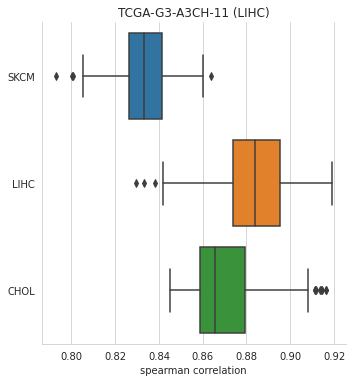

In [63]:
fig = sns.catplot(kind='box', data=corr, x='correlation', y='cancer type abbreviation')
title = test_sample_id + ' (' + meta_df[meta_df['sample'] == test_sample_id].iloc[0]['cancer type abbreviation'] +')'
fig.set(xlabel='spearman correlation', ylabel='', title=title)

As expected, the average pairwise correlation is highest within the same disease cohort as the sample